# How analyze individual spectral lines

Many of the tools in SpecpolFlow can be applied to a single line in an observed spectrum.  In this example we analyze a few emission lines in the spectrum of a T Tauri star.

First, import SpecpolFlow and some packages that will help with data visualization.

In [1]:
import specpolFlow as pol

import pandas as pd
import matplotlib.pyplot as plt

## 1. Create individual line file

In this tutorial, we use the UPENA normalized spectrum ([IndividualLine_tutorialfiles/1423137pn.s](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/IndividualLine_tutorialfiles/1423137pn.s)) of the active cool star BP Tau.

We first load in the spectrum. 

In [2]:
spec = pol.read_spectrum("IndividualLine_tutorialfiles/1423137pn.s")

To create extract an individual line from the spectrum, we have to define the transition wavelength `lambda0` and a range with respect to the line center. In the example below, we select the HeI line at 667.815 nm in a 0.6 nm window.

In [3]:
# Create individual line profile 
lambda0 = 667.815 # He i 667.815 nm
geff = 1.0 # He i 667.815 nm, used later for calculating Bz
lwidth = 0.3 

prof = spec.individual_line(lambda0 = lambda0, lwidth = lwidth)

The `individual_line` function returns `prof`, which is really an LSD profile object, and inherits all the attributes from the LSD class. Therefore, you can use all the functionality discussed in the [LSD Class Tutorial](5-LSDClass_Tutorial.ipynb) (i.e., one can normalize, slice, or shift the line profile).

Below, we visualize the individual line using the `plot` class function. 

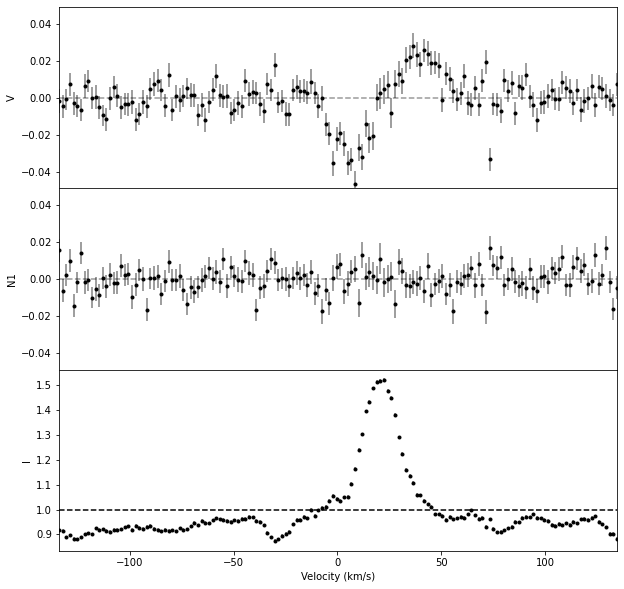

In [4]:
fig, axes = prof.plot()
axes[-1].axhline(1, color ='k', ls = '--')

## 2. Calculate Bz

To calculate the longitudinal field (Bz) of the individual line, we can use the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz`</a> function of the LSD class.

using AUTO method for the normalization
  using the median of the continuum outside of the line


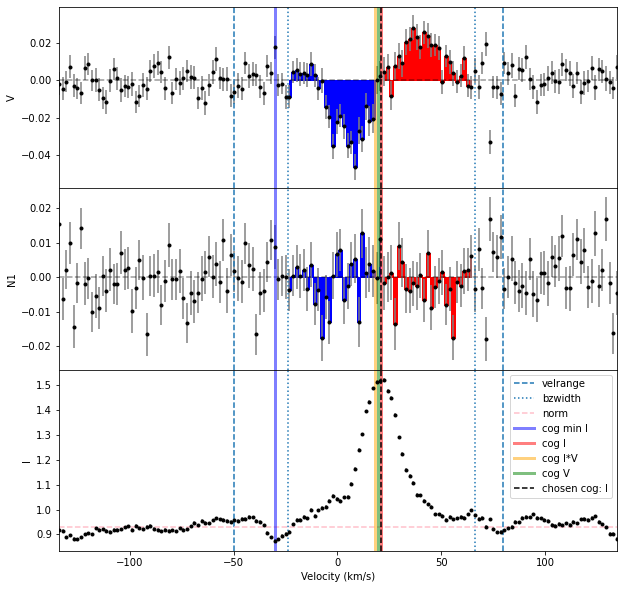

In [5]:
# Define the limits for the continuum normalization
cmin = -50.0; cmax = 80.0

# Compute Bz in a 45 km/s window
Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                   velrange = [cmin, cmax], bzwidth = 45.0, 
                   geff = geff, lambda0 = lambda0,
                   plot = True)

We can then display the results using the pandas dataframe. For this particular line, we find Bz $= 1.2 \pm 0.1$ kG.

In [6]:
Bz_df = pd.DataFrame(data = [Bz])

# Simple display of the pandas dataframe
Bz_df.style

,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,1191.652271,130.184898,0.000000,-34.686996,130.041356,0.564259,0.000000,0.000000,0.000000,auto,0.931285,I,21.173209,-23.826791,66.173209


## 3. Normalize the individual line

In the figure above, we see that `calc_bz` improved the continuum normalization, taking the median of the continuum outside of the line. 
Therefore, we propagate this normalization in the `prof` object before saving the individual line profile into a file.

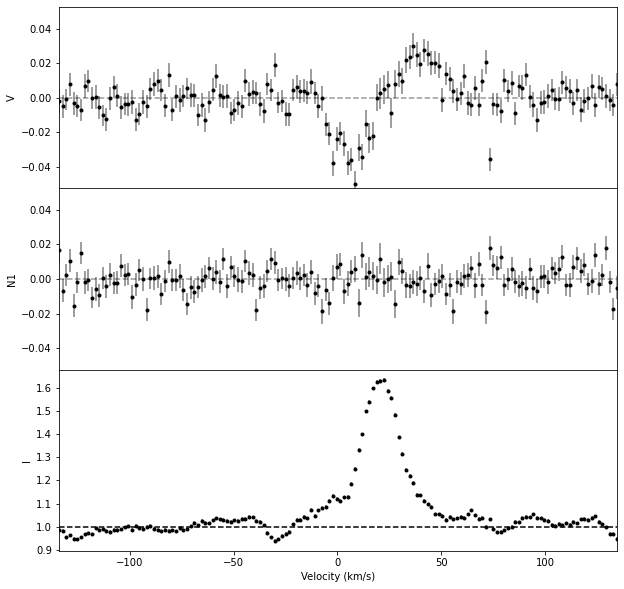

In [7]:
# Renormalize prof using the continuum value obtained by calc_bz
prof_norm = prof.norm(Bz['norm'])

# Display the profile
fig, axes = prof_norm.plot()
axes[-1].axhline(1, color = 'k', ls = '--')

## 4. Saving individual lines

Finally, you can save the individual line into a file using the `save` function, shown below.  This file will have a text format like an LSD profile.

In [8]:
prof_norm.save("Output/1423137.Helium")

## 5. Dealing with order overlaps

Now, let's do the same for the Halpha line.  However, there is a complication, the Halpha line is split across two orders in this echelle spectrum. 

using AUTO method for the normalization
  using the median of the continuum outside of the line


/tmp/ipykernel_980312/871814974.py:13: UserWarning: 
 The velocity array is not monotonically increasing. 
 There might be an order overlap in the region of the observation used. 
 calc_bz will sort the LSD profile in velocity order. 
 Make sure this is what you want -- merge orders before running calc_bz()!
  Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I',


,Merge type,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,None,72.964936,17.843167,0.000000,7.405907,17.843162,0.435065,0.000000,0.000000,0.000000,auto,1.101100,I,9.725353,-190.274647,209.725353


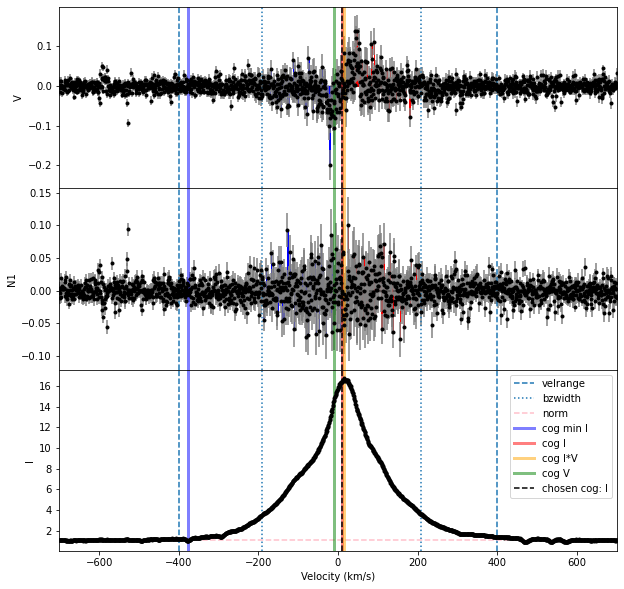

In [9]:
# reading the spectrum
spec = pol.read_spectrum("IndividualLine_tutorialfiles/1423137pn.s")
# defining the line parameters
lambda0 = 656.281 ;  geff = 1.0 # Halpha
lwidth = 700. * lambda0 / 2.99e5 #convert a 700 km/s width into a width in nm
# getting the profile for that line
prof = spec.individual_line(lambda0 = lambda0, lwidth = lwidth)

# Define the limits for the continuum normalization
# Compute Bz in a 200 km/s window around the cog
cogRange = [-400., 400.]
intRange = 200.
Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                       velrange = cogRange, bzwidth = intRange, 
                       geff = geff, lambda0 = lambda0,
                       plot = True)   

# Create a dataframe to record the result of the different methods in this section
d = {'Merge type':'None'}
d.update(Bz)
df_results = pd.DataFrame(data = [d])
df_results.style

The calc_bz function gave us a warning about there probably being different spectral orders here. And the plot of results is relatively messy.  

### 5.1 Option 1: Selecting only one order

The simplest solution to this problem is to only use one spectral order for the Bz calculation.  In the case of this Halpha line, both orders include the center of the line that we are interested in.  So we can calculate Bz from the two orders separately.  

To get the spectral orders that include a wavelength, or range of wavelengths, we can use the <a href='../API/Spectrum_API.html#specpolFlow.Spectrum.get_orders_in_range'>`get_orders_in_range`</a> function of the `Spectrum` class.  This returns a list containing `Spectrum` objects for each order.  

There are 2 orders with Halpha in them
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


,Merge type,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,None,72.964936,17.843167,0.000000,7.405907,17.843162,0.435065,0.000000,0.000000,0.000000,auto,1.101100,I,9.725353,-190.274647,209.725353
1,lower only,94.012588,25.428151,0.000003,5.209152,25.428140,0.221315,0.000000,0.000000,0.000000,auto,1.104800,I,14.197130,-185.802870,214.197130
2,higher only,54.213318,21.662775,0.000007,3.435552,21.662771,0.803308,0.000000,0.000000,0.000000,auto,1.096300,I,13.943177,-186.056823,213.943177


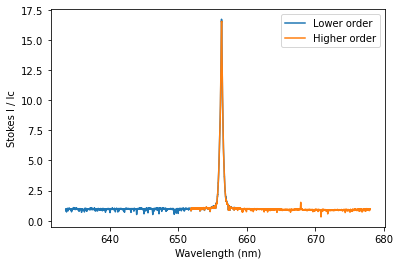

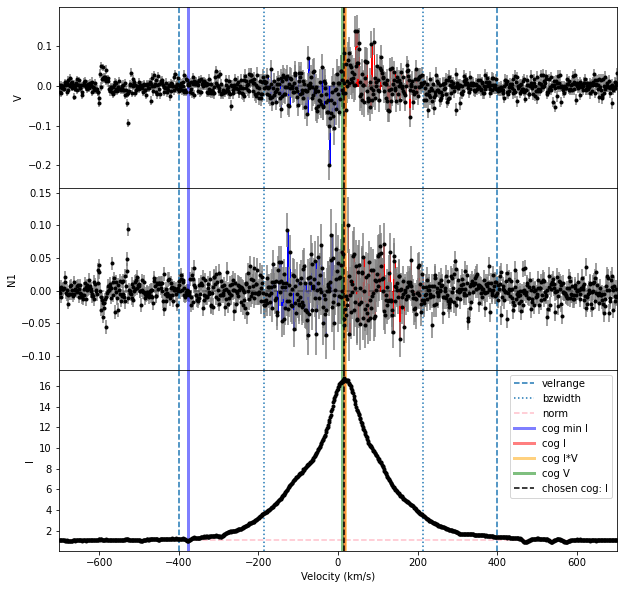

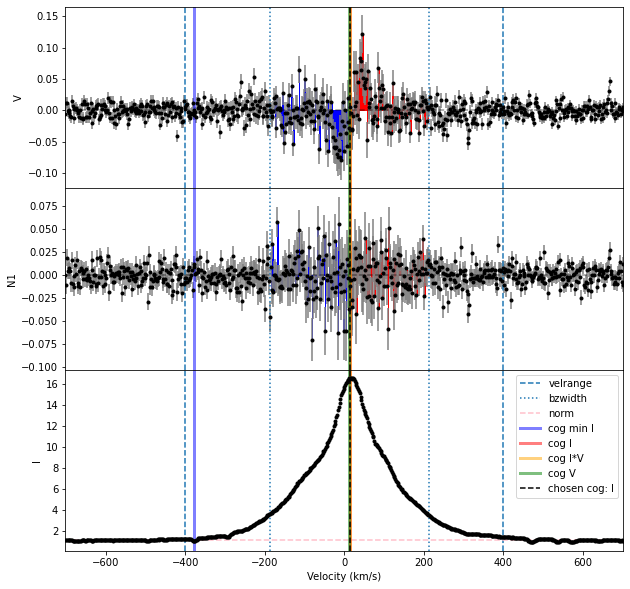

In [10]:
## Selecting only one order
orders = spec.get_orders_in_range(lambda0)
print('There are {} orders with Halpha in them'.format(len(orders)))

# Illustration of the order overlap
fig, ax = plt.subplots(1,1)
ax.plot(orders[0].wl, orders[0].specI, label = 'Lower order')
ax.plot(orders[1].wl, orders[1].specI, label = 'Higher order')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Stokes I / Ic')
ax.legend(loc = 0)

# loop over the orders
type = ['lower only', 'higher only']
i = 0
for ord in orders:

    # get the profile for the line in this order
    prof = ord.individual_line(lambda0 = lambda0, lwidth = lwidth)

    # compute Bz, in the defined velocity window around the cog
    Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                           velrange = cogRange, bzwidth = intRange, 
                           geff = geff, lambda0 = lambda0,
                           plot = True)
    d = {'Merge type':type[i]}
    d.update(Bz)
    df = pd.DataFrame(data=[d])
    df_results = pd.concat([df_results,df], ignore_index=True)
    i += 1

# display the Bz result as a dataframe
df_results.style

### 5.2 Option 2: merging the orders

An alternative solution is to merge the spectral orders before calculating Bz. Combining orders is more complex, but it can optimize S/N, and it can be useful when the wavelength range of interest extends beyond the edge of an order.

We can combine spectral orders with the <a href='../API/Spectrum_API.html#specpolFlow.Spectrum.merge_orders'>`merge_orders`</a> function of the `Spectrum` class.  This function provides two methods of combining orders `'trim'` and `'coadd'`.  This function only really works properly if the continuum levels are consistent between orders.  

In `merge_orders` with `mode = 'trim'`, the function just uses the first order up to the midpoint of the region where the orders overlap, then it uses the second order beyond that midpoint.  This approach is relatively simple and essentially throws away a bit of signal.  But it is more robust against errors in continuum normalization (or spectrum extraction) at the edges of spectral orders, and these errors are relatively common.  

In `merge_orders` with `mode = 'coadd'`, the function essentially averages the orders, weighted by the uncertainties on individual pixels (specifically by $1/\sigma^2$).  To do this it needs to interpolate in wavelength, and it uses the wavelengths from the first order, interpolating the second order onto that grid.  This mode requires reliable uncertainties for the Stokes I spectrum.  This approach has the advantage that it optimizes the S/N in the merged spectrum. But it is more vulnerable to continuum normalization errors at the edges of orders, since an error in either order will cause problems for the merged result.

Here we try out both methods to compare the results.  In this case the normalization is pretty good in the region we care about, so the `'coadd'` mode gives a more precise result.

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


,Merge type,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,None,72.964936,17.843167,0.000000,7.405907,17.843162,0.435065,0.000000,0.000000,0.000000,auto,1.101100,I,9.725353,-190.274647,209.725353
1,lower only,94.012588,25.428151,0.000003,5.209152,25.428140,0.221315,0.000000,0.000000,0.000000,auto,1.104800,I,14.197130,-185.802870,214.197130
2,higher only,54.213318,21.662775,0.000007,3.435552,21.662771,0.803308,0.000000,0.000000,0.000000,auto,1.096300,I,13.943177,-186.056823,213.943177
3,trim at mid-point,54.213318,21.662775,0.000007,3.435552,21.662771,0.803308,0.000000,0.000000,0.000000,auto,1.096300,I,13.943177,-186.056823,213.943177
4,coadd,69.328145,15.158243,0.000000,5.479275,15.158239,0.999346,0.000000,0.000000,0.000000,auto,1.098296,I,14.040448,-185.959552,214.040448


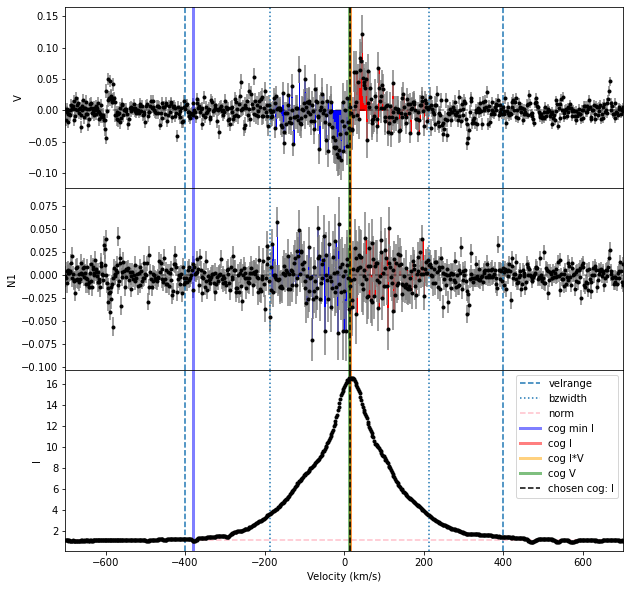

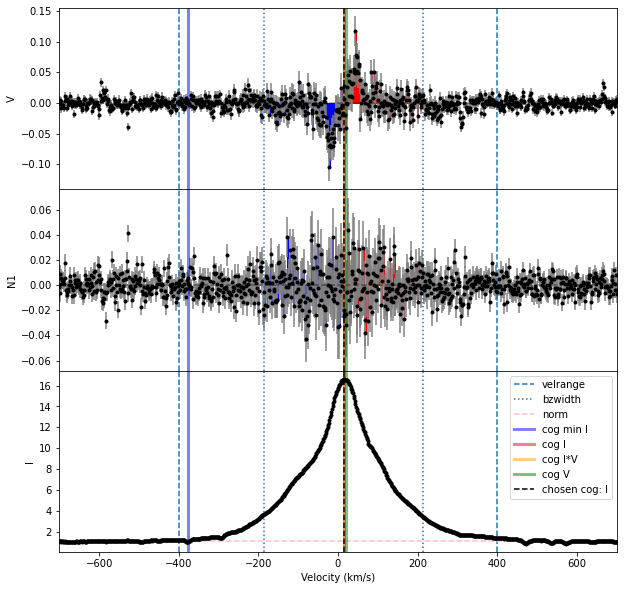

In [11]:
## Merging using the trim method
merge = spec.merge_orders(mode = 'trim', midpoint = 0.5)

prof = merge.individual_line(lambda0 = lambda0, lwidth = lwidth)
Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                       velrange = cogRange, bzwidth = intRange, 
                       geff = geff, lambda0 = lambda0,
                       plot = True)
d = {'Merge type':'trim at mid-point'}
d.update(Bz)
df = pd.DataFrame(data = [d])
df_results = pd.concat([df_results,df], ignore_index=True)


## Merging using the coadd method
merge = spec.merge_orders(mode='coadd')

prof = merge.individual_line(lambda0 = lambda0, lwidth = lwidth)
Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                       velrange = cogRange, bzwidth = intRange, 
                       geff = geff, lambda0 = lambda0,
                       plot = True)
d = {'Merge type':'coadd'}
d.update(Bz)
df = pd.DataFrame(data = [d])
df_results = pd.concat([df_results,df], ignore_index = True)

# Display the Bz result as a dataframe
df_results.style

The Halpha line is somewhat complicated to analyze, in that it has a very broad emission component from regions not associated with the magnetic field.  This makes the correct velocity range to use for integration in the Bz calculation ambiguous.

For a somewhat cleaner example that is still in a region where two spectral orders overlap, we can look at the He I 587.56 nm line.

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


/tmp/ipykernel_980312/2408171684.py:13: UserWarning: 
 The velocity array is not monotonically increasing. 
 There might be an order overlap in the region of the observation used. 
 calc_bz will sort the LSD profile in velocity order. 
 Make sure this is what you want -- merge orders before running calc_bz()!
  Bz = prof.calc_bz(norm = 'auto', cog = 'I',


,Merge type,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,None,699.503139,66.521645,0.000000,49.584163,66.504701,0.000385,0.000000,0.000000,0.000000,auto,0.991090,I,18.941158,-31.058842,68.941158
1,lower only,822.700767,91.691815,0.000000,-17.652850,91.658895,0.031436,0.000000,0.000000,0.000000,auto,0.992395,I,25.706350,-24.293650,75.706350
2,higher only,793.994679,90.964654,0.000000,220.357069,90.937349,0.002410,0.000000,0.000000,0.000000,auto,0.990170,I,25.578820,-24.421180,75.578820
3,trim at mid-point,797.884180,91.419382,0.000000,221.513065,91.391673,0.002410,0.000000,0.000000,0.000000,auto,0.993520,I,25.587490,-24.412510,75.587490
4,coadd,805.924582,60.001692,0.000000,116.774813,59.981432,0.097482,0.000000,0.000000,0.000000,auto,0.990281,I,25.660364,-24.339636,75.660364


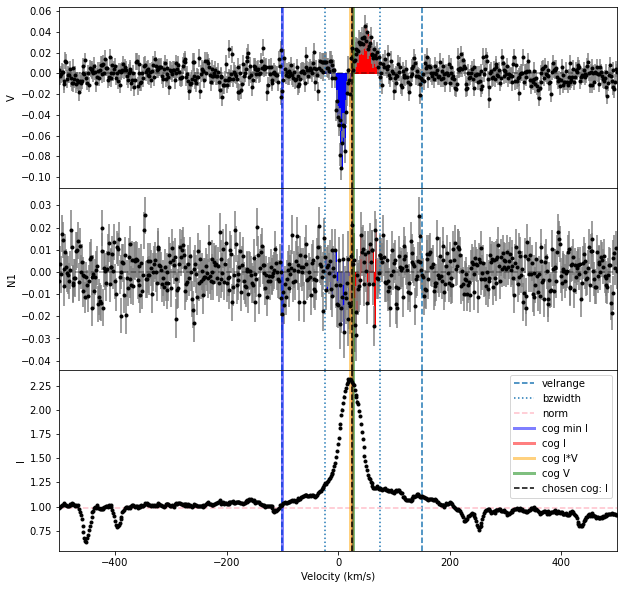

In [12]:
# reading the spectrum
spec = pol.read_spectrum("IndividualLine_tutorialfiles/1423137pn.s")
# defining the line parameters
lambda0 = 587.56 ;  geff = 1.0 # He I 587, really a multiplet (so geff is rather approximate)
lwidth = 500. * lambda0 / 2.99e5 #width in nm from width in km/s
# getting the profile for that line
prof = spec.individual_line(lambda0 = lambda0, lwidth = lwidth)

# define the limits for the continuum normalization
# compute Bz in a 50 km/s window around the cog
cogRange = [-100., 150.]
intRange = 50.
Bz = prof.calc_bz(norm = 'auto', cog = 'I', 
                  velrange = cogRange, bzwidth = intRange, 
                  geff = geff, lambda0 = lambda0,
                  plot = False)   

# creating a dataframe to record the result of the different methods in this section
d = {'Merge type':'None'}
d.update(Bz)
df_results = pd.DataFrame(data = [d])

orders = spec.get_orders_in_range(lambda0)
# loop over the individual orders
for ord, type in zip(orders,['lower only', 'higher only']):
    # get the profile for the line in this order
    prof = ord.individual_line(lambda0 = lambda0, lwidth = lwidth)
    Bz = prof.calc_bz(norm = 'auto', cog = 'I', 
                           velrange = cogRange, bzwidth = intRange, 
                           geff = geff, lambda0 = lambda0,
                           plot = False)
    d = {'Merge type':type}
    d.update(Bz)
    df = pd.DataFrame(data = [d])
    df_results = pd.concat([df_results,df], ignore_index=True)

# merging using the trim method
merge = spec.merge_orders(mode = 'trim', midpoint = 0.5)
prof = merge.individual_line(lambda0 = lambda0, lwidth = lwidth)
Bz = prof.calc_bz(norm = 'auto', cog = 'I', 
                  velrange = cogRange, bzwidth = intRange, 
                  geff = geff, lambda0 = lambda0,
                  plot = False)
d = {'Merge type':'trim at mid-point'}
d.update(Bz)
df = pd.DataFrame(data = [d])
df_results = pd.concat([df_results,df], ignore_index=True)

# merging using the coadd method
merge = spec.merge_orders(mode = 'coadd')
prof = merge.individual_line(lambda0 = lambda0, lwidth = lwidth)
Bz, fig = prof.calc_bz(norm = 'auto', cog = 'I', 
                       velrange = cogRange, bzwidth = intRange, 
                       geff = geff, lambda0 = lambda0,
                       plot = True)
d = {'Merge type':'coadd'}
d.update(Bz)
df = pd.DataFrame(data = [d])
df_results = pd.concat([df_results,df], ignore_index=True)

# display the Bz result as a dataframe
df_results.style